# Data quality controll
## Flavornet data matching with Whisky research data

In [6]:
import pandas as pd
import csv
from fuzzywuzzy import process
from fuzzywuzzy import fuzz


c:\Users\Franz\AppData\Local\Programs\Python\Python39\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


*Flavornet data*

In [80]:
# only using flavornet data
mol_to_OD = {}
CAS_OD = {}
molecules = []
descriptors = []
with open('./data/CAS_mol_OD.csv', 'r',encoding='utf-8') as tabfile:
    reader = csv.reader(tabfile, delimiter=',')
    for row in reader: 
        molecule = row[0]
        CAS = row[1]
        OD = row[3]
        molecules.append(molecule)
        descriptors.append(OD)
        if CAS in mol_to_OD:
            mol_to_OD[CAS].add(OD)
        else:
            mol_to_OD[CAS]  = set([OD])

molecules = list(set(molecules))
descriptors = list(set(descriptors))

In [84]:
# key = CAS (727), value = odorant (197)
# 727 cas numbers
mol_to_OD

{'6485-40-1': {'mint'},
 '3033-23-6': {'rose', 'sweet'},
 '21284-22-0': {'green tea', 'herb', 'spice'},
 '38427-78-0': {'terpentine'},
 '495-61-4': {'balsamic'},
 '29873-99-2': {'green', 'oil', 'wood'},
 '6909-30-4': {'green'},
 '99-49-0': {'basil', 'caraway', 'fennel', 'mint'},
 '2244-16-8': {'caraway'},
 '876-17-5': {'flower', 'green'},
 '5989-27-5': {'citrus', 'mint'},
 '4674-50-4': {'grapefruit'},
 '2243-33-6': {'dill'},
 '10307-61-6': {'apple'},
 '69064-37-5': {'oil'},
 '85761-70-2': {'green', 'leaf'},
 '6728-26-3': {'apple', 'fat', 'green', 'leaf', 'rancid'},
 '13419-69-7': {'fat', 'must'},
 '928-95-0': {'green', 'leaf', 'walnut'},
 '18829-56-6': {'cucumber', 'fat', 'green'},
 '1576-96-1': {'mushroom'},
 '53448-07-0': {'fat', 'green', 'soap'},
 '928-97-2': {'fresh', 'moss'},
 '1197-07-5': {'caraway', 'solvent'},
 '14371-10-9': {'cinnamon', 'paint'},
 '09.04.5948': {'herb', 'warm'},
 '106-28-5': {'muguet'},
 '5273-85-8': {'flower', 'spice'},
 '5932-68-3': {'flower'},
 '4959-35-7':

*Research data*

In [57]:
Research_data = pd.read_csv('./data/swri_flavorwheel.csv', sep=';')
OSA_research = Research_data['OSA'].unique()
OQ_research = Research_data['OQ'].unique()
OD_research = Research_data['OD'].unique()

In [58]:
Research_OD_OSA = Research_data.drop(columns=Research_data.columns[1])
Research_OD_OSA


,OSA,OD
0,Peaty,Tar
1,Peaty,char
2,Peaty,ash
3,Peaty,Burning wood
4,Peaty,smoked foods barbeque
...,...,...
138,Spicy,Spicy
139,Oily,Oily
140,Sour,Sour
141,Sulphury,Sulphury


In [125]:
Research_OD_OSA['OSA'].value_counts()
# shows that some OSAs are descriped by more attributes so they are more likely to get matches

Fruity          17
Sulphury        17
Nutty           12
Oily            12
Peaty           11
Green/grassy    10
Sweet           10
Cereal           9
Stale            9
Sour             8
Feinty           7
Floral           6
Spicy            6
Woody            5
Solvently        2
Soapy            2
Name: OSA, dtype: int64

In [90]:
flavors_list = []

for cas, flavors in mol_to_OD.items():
    for flavor in flavors:
        flavors_list.append({'CAS': cas, 'OD': flavor})

CAS_OD = pd.DataFrame(flavors_list)

In [91]:
CAS_OD

,CAS,OD
0,6485-40-1,mint
1,3033-23-6,sweet
2,3033-23-6,rose
3,21284-22-0,spice
4,21284-22-0,herb
...,...,...
1334,20307-84-0,wood
1335,120021-96-7,oil
1336,586-62-9,plastic
1337,586-62-9,pine


In [119]:
# Function to perform fuzzy matching
def fuzzy_match(row):
    match = Research_OD_OSA[Research_OD_OSA['OD'].apply(lambda x: fuzz.ratio(row['OD'], x)) >= 70]
    if len(match) > 0:
        return pd.Series([row['CAS'], match.iloc[0]['OD'], match.iloc[0]['OSA']])
    else:
        return pd.Series([row['CAS'], None, None])
    
# Apply fuzzy matching
result_df = CAS_OD.apply(fuzzy_match, axis=1)
result_df.columns = ['CAS', 'OD', 'OSA']

print(result_df)


              CAS         OD       OSA
0       6485-40-1       None      None
1       3033-23-6  sweetcorn  Sulphury
2       3033-23-6       None      None
3      21284-22-0       None      None
4      21284-22-0       None      None
...           ...        ...       ...
1334   20307-84-0       None      None
1335  120021-96-7       None      None
1336     586-62-9       None      None
1337     586-62-9       None      None
1338     710-04-3       None      None

[1339 rows x 3 columns]


In [97]:
# remove Nones
result_df = result_df.dropna()
print(result_df)

             CAS            OD       OSA
1      3033-23-6     sweetcorn  Sulphury
21     4674-50-4    grapefruit    Fruity
23    10307-61-6        Apples    Fruity
30     6728-26-3        rancid      Sour
31     6728-26-3        Apples    Fruity
...          ...           ...       ...
1323  13466-78-9        Lemons    Fruity
1329    705-86-2  coconut milk     Nutty
1331   2825-91-4  coconut milk     Nutty
1332    713-95-1     sweetcorn  Sulphury
1333    713-95-1        Fruity    Fruity

[365 rows x 3 columns]


####  count appearance of OSA

In [114]:
import matplotlib.pyplot as plt
flavor_counts = result_df['OSA'].value_counts()

In [124]:
flavor_counts

Fruity          122
Sulphury         76
Stale            35
Nutty            33
Sour             19
Green/grassy     15
Feinty           12
Woody            12
Oily              9
Sweet             9
Spicy             8
Cereal            6
Solvently         5
Floral            4
Name: OSA, dtype: int64

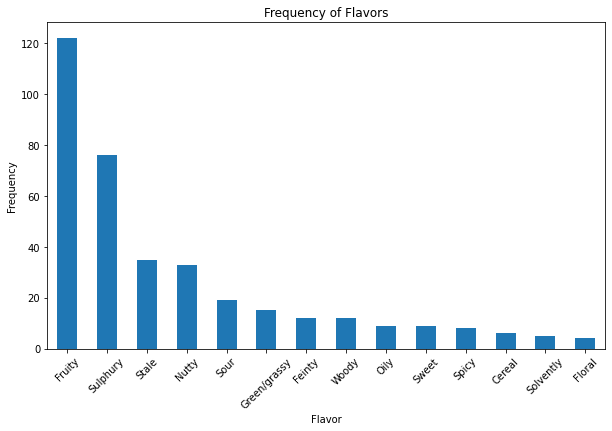

In [118]:
# Sorting by value
flavor_counts_sorted = flavor_counts.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
flavor_counts_sorted.plot(kind='bar')
plt.title('Frequency of Flavors')
plt.xlabel('Flavor')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [13]:
'''
find overlapp between to lists with a threshold (=70)
'''
def overlapping_elements(list1, list2, threshold=70):
    overlap = []
    overlap_tuples= []
    for elem1 in list1:
        for elem2 in list2:
            ratio = fuzz.ratio(elem1, elem2)
            if ratio >= threshold:
                overlap.append(elem1)
                overlap_tuples.append((elem1,elem2))
    return overlap_tuples

In [14]:
overlapping_pairs = overlapping_elements(OD_research,descriptors)

In [16]:
len(overlapping_pairs)

59

In [66]:
len(overlapping_pairs)/len(OD_research)

0.375

##### matches to 37,5 %
##### another database could be used to match odorants from research institute

### panelist data
#### get panelist data with largest variance

In [3]:
import pandas as pd
file_path = 'data/vlb_data_combined.txt'
data = pd.read_csv(file_path, delimiter=',')
# only use first repliate
data

,panelist,samplekey,floral,fruit,wood,complexity,malt,sweet,peat,dried_fruits,aftertaste,date
0,1,000656,50,20,60,50,30,30,50,40,40,2023-01-12
1,1,000657,30,40,60,40,40,30,10,30,60,2023-01-12
2,1,000658,30,50,50,50,40,40,10,40,70,2023-01-12
3,1,000661,60,70,60,50,50,60,0,40,60,2023-01-12
4,1,000662,40,60,50,50,50,40,0,30,60,2023-01-12
...,...,...,...,...,...,...,...,...,...,...,...,...
1241,3,000926,40,30,40,40,30,20,40,20,60,2022-10-17
1242,3,000927,40,70,60,70,40,50,0,40,80,2022-10-17
1243,3,000929,20,60,30,40,30,50,0,40,30,2022-10-17
1244,3,000930,10,30,60,70,30,70,0,40,60,2022-10-17


In [8]:
import itertools
# find rows with biggest variances
df = data.drop(columns=["panelist","samplekey","date"])
row_combinations = list(itertools.combinations(df.index, 2))
distances = [abs(df.loc[i[0]] - df.loc[i[1]]).sum() for i in row_combinations]
max_distance_indices = row_combinations[distances.index(max(distances))]
print(df.loc[max_distance_indices[0]])
print(df.loc[max_distance_indices[1]])
#=> sample: 000673 and 000794 but both not in masspec

floral          60
fruit           20
wood            50
complexity      30
malt            20
sweet           20
peat            80
dried_fruits    10
aftertaste      40
Name: 12, dtype: int64
floral          40
fruit           60
wood            80
complexity      70
malt            60
sweet           70
peat             0
dried_fruits    60
aftertaste      80
Name: 159, dtype: int64


In [11]:
data.iloc[159]

panelist                 2
samplekey           000794
floral                  40
fruit                   60
wood                    80
complexity              70
malt                    60
sweet                   70
peat                     0
dried_fruits            60
aftertaste              80
date            2023-01-12
Name: 159, dtype: object

In [10]:
data.iloc[12]

panelist                 1
samplekey           000673
floral                  60
fruit                   20
wood                    50
complexity              30
malt                    20
sweet                   20
peat                    80
dried_fruits            10
aftertaste              40
date            2023-01-12
Name: 12, dtype: object